# Pipeline Counts

Keeping track of the number of sequences at each step of the processing pipeline

In [98]:
# loading libraries
library(tidyverse)
library(ggrepel)

### raw reads

In [3]:
novogene_qc <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/processing/qc_outputs/novogene_qc.summary.csv') 
head(novogene_qc)

,Sample,Raw.reads,Raw.data,Effective...,Error...,Q20...,Q30...,GC...
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,C1_H6_W62_gi,65297220,9794583000,98.99,0.01,99.47,97.68,42.30
2,B4_W6_O67_gi,73117894,10967684100,99.06,0.01,99.42,97.50,42.09
3,H3_W6_B66_gi,60215268,9032290200,98.67,0.01,99.43,97.47,42.28
4,W6_H6_G71_gi,66355872,9953380800,98.96,0.01,99.47,97.66,42.38
5,H1_B6_B61_gi,69802722,10470408300,98.84,0.01,99.45,97.64,42.12
6,H4_H2_B19_gi,79683032,11952454800,98.81,0.01,99.44,97.63,42.47


In [4]:
pipe_count <- novogene_qc %>%
select(Sample, Raw.reads)

colnames(pipe_count)[2] <- 'raw.reads'

head(pipe_count)

,Sample,raw.reads
,<chr>,<int>
1,C1_H6_W62_gi,65297220
2,B4_W6_O67_gi,73117894
3,H3_W6_B66_gi,60215268
4,W6_H6_G71_gi,66355872
5,H1_B6_B61_gi,69802722
6,H4_H2_B19_gi,79683032


### trimmed reads

`trim-galore` returns a trimming report for R1 and R2 for paired-end, but the R1 report is printed *before* validation - so therefore it does not contain information for what has been filtered (it will always be 100% retained) - so have to look at the bottom of the trimming report for R2, which contains info on how many sequences were analyzed and how many were removed. From there, you can subtract how many were removed to get how many reads were trimmed and passed filtering.

first - run in command line:

```
echo "file,total_sequences,removed_pairs" > summary.csv

awk '
/Total number of sequences analysed/ {
    total = $NF
}
/Number of sequence pairs removed/ {
    removed = $(NF-1)
}
FNR==1 {
    total = removed = ""
}
ENDFILE {
    if (total && removed)
        print FILENAME "," total "," removed
}
' *2.fq.gz_trimming_report.txt >> summary.csv
```

In [5]:
trim.reads <- read.csv('/scratch4/workspace/julia_mcdonough_student_uml_edu-novogene_dwnld/trimmed_all/summary.csv')
head(trim.reads)

,file,total_sequences,removed_pairs
,<chr>,<int>,<int>
1,B1_B1_O01_gi_2.fq.gz_trimming_report.txt,35532537,27356
2,B1_Nu_O03_gi_2.fq.gz_trimming_report.txt,50278071,32294
3,B1_W5_O50_gi_2.fq.gz_trimming_report.txt,33889636,23032
4,B2_B5_O51_gi_2.fq.gz_trimming_report.txt,38004478,24591
5,B2_C4_O40_gi_2.fq.gz_trimming_report.txt,38581393,24910
6,B2_Nu_O12_gi_2.fq.gz_trimming_report.txt,51204574,34557


In [6]:
# get just the sample name
trimmed <- trim.reads %>%
separate(col = file,
         into = c('Sample', 'extra'),
         sep = "\\_2.fq.gz_trimming")

# remove extra col
trimmed <- trimmed[,c(1,3,4)]

# calculate number of retained pairs
trimmed$paired.reads <- trimmed$total_sequences - trimmed$removed_pairs

head(trimmed)

,Sample,total_sequences,removed_pairs,paired.reads
,<chr>,<int>,<int>,<int>
1,B1_B1_O01_gi,35532537,27356,35505181
2,B1_Nu_O03_gi,50278071,32294,50245777
3,B1_W5_O50_gi,33889636,23032,33866604
4,B2_B5_O51_gi,38004478,24591,37979887
5,B2_C4_O40_gi,38581393,24910,38556483
6,B2_Nu_O12_gi,51204574,34557,51170017


In [7]:
# keep only sample and paired_reads
trim <- trimmed %>%
select(Sample, paired.reads)

head(trim)

,Sample,paired.reads
,<chr>,<int>
1,B1_B1_O01_gi,35505181
2,B1_Nu_O03_gi,50245777
3,B1_W5_O50_gi,33866604
4,B2_B5_O51_gi,37979887
5,B2_C4_O40_gi,38556483
6,B2_Nu_O12_gi,51170017


In [8]:
pipe.counts <- merge(pipe_count, trim, by = 'Sample')
head(pipe.counts)

,Sample,raw.reads,paired.reads
,<chr>,<int>,<int>
1,B1_B1_O01_gi,71065074,35505181
2,B1_Nu_O03_gi,100556142,50245777
3,B1_W5_O50_gi,67779272,33866604
4,B2_B5_O51_gi,76008956,37979887
5,B2_C4_O40_gi,77162786,38556483
6,B2_Nu_O12_gi,102409148,51170017


to get number of reads successfully paired:

In [9]:
pipe.counts$total.success.paired <- pipe.counts$paired.reads * 2
head(pipe.counts)

,Sample,raw.reads,paired.reads,total.success.paired
,<chr>,<int>,<int>,<dbl>
1,B1_B1_O01_gi,71065074,35505181,71010362
2,B1_Nu_O03_gi,100556142,50245777,100491554
3,B1_W5_O50_gi,67779272,33866604,67733208
4,B2_B5_O51_gi,76008956,37979887,75959774
5,B2_C4_O40_gi,77162786,38556483,77112966
6,B2_Nu_O12_gi,102409148,51170017,102340034


### aligned reads
after running `hisat2`

to run in command line:
```
grep -H "overall alignment rate" *.log >align_rate.csv
```

reporting overall alignment rate, which is the combination of concordant alignments, discordant alignments, and one mate aligned

In [52]:
# read in csv
align.rate <- read.csv('/scratch4/workspace/julia_mcdonough_student_uml_edu-novogene_dwnld/hisat2-align/align_rate.csv', header = FALSE, sep = ':')

# format sample name
align.rate$V1 <- gsub('.log', '_gi', align.rate$V1)

# remove text from alignment rate
align.rate$V2 <- as.numeric(gsub('% overall alignment rate', '', align.rate$V2))

# rename columns
colnames(align.rate) <- c('Sample', 'overall.align.rate.percent')

head(align.rate)

,Sample,overall.align.rate.percent
,<chr>,<dbl>
1,B1_B1_O01_gi,81.18
2,B1_Nu_O03_gi,81.56
3,B1_W5_O50_gi,82.27
4,B2_B5_O51_gi,82.88
5,B2_C4_O40_gi,82.03
6,B2_Nu_O12_gi,83.02


In [53]:
dim(align.rate)

[1] 120   2

In [54]:
counts <- merge(pipe.counts, align.rate, by = 'Sample')
head(counts)

,Sample,raw.reads,paired.reads,total.success.paired,overall.align.rate.percent
,<chr>,<int>,<int>,<dbl>,<dbl>
1,B1_B1_O01_gi,71065074,35505181,71010362,81.18
2,B1_Nu_O03_gi,100556142,50245777,100491554,81.56
3,B1_W5_O50_gi,67779272,33866604,67733208,82.27
4,B2_B5_O51_gi,76008956,37979887,75959774,82.88
5,B2_C4_O40_gi,77162786,38556483,77112966,82.03
6,B2_Nu_O12_gi,102409148,51170017,102340034,83.02


In [55]:
# calculate number of aligned reads based on rate
counts$aligned.paired.reads <- (counts$overall.align.rate/100) * (counts$paired.reads)

# remove _gi from end of sample name
counts$Sample <- gsub('_gi', '', counts$Sample)

head(counts)

,Sample,raw.reads,paired.reads,total.success.paired,overall.align.rate.percent,aligned.paired.reads
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,B1_B1_O01,71065074,35505181,71010362,81.18,28823106
2,B1_Nu_O03,100556142,50245777,100491554,81.56,40980456
3,B1_W5_O50,67779272,33866604,67733208,82.27,27862055
4,B2_B5_O51,76008956,37979887,75959774,82.88,31477730
5,B2_C4_O40,77162786,38556483,77112966,82.03,31627883
6,B2_Nu_O12,102409148,51170017,102340034,83.02,42481348


### read counting
from `featureCounts`

In [56]:
# read in csv
fc <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/processing/qc_outputs/featureCounts_summary.csv')

# format sample name
fc$Sample <- gsub('counts_', '', fc$Sample)

head(fc)

,Sample,Assigned,Unassigned_Unmapped,Unassigned_Read_Type,Unassigned_Singleton,Unassigned_MappingQuality,Unassigned_Chimera,Unassigned_FragmentLength,Unassigned_Duplicate,Unassigned_MultiMapping,Unassigned_Secondary,Unassigned_NonSplit,Unassigned_NoFeatures,Unassigned_Overlapping_Length,Unassigned_Ambiguity
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,B1_B1_O01,43560302,13364315,0,0,0,0,0,0,17626841,0,0,7292854,0,1315530
2,B1_Nu_O03,61112992,18535006,0,0,0,0,0,0,27272204,0,0,10638161,0,1889859
3,B1_W5_O50,41697027,12006768,0,0,0,0,0,0,19337191,0,0,7014364,0,1263414
4,B2_B5_O51,46515407,13001667,0,0,0,0,0,0,21897610,0,0,8567980,0,1410398
5,B2_C4_O40,45537802,13858521,0,0,0,0,0,0,25570278,0,0,9058567,0,1460110
6,B2_Nu_O12,62786888,17374948,0,0,0,0,0,0,22900081,0,0,12562764,0,1714702


In [57]:
# select only assigned reads column
fc.assign <- fc %>%
select(Sample, Assigned) 

# change column name
colnames(fc.assign)[2] <- 'total.assigned.reads'

# divie total.assigned reads to get total paired assigned?
fc.assign$paired.assigned.reads <- fc.assign$total.assigned.reads / 2


head(fc.assign)

,Sample,total.assigned.reads,paired.assigned.reads
,<chr>,<int>,<dbl>
1,B1_B1_O01,43560302,21780151
2,B1_Nu_O03,61112992,30556496
3,B1_W5_O50,41697027,20848514
4,B2_B5_O51,46515407,23257704
5,B2_C4_O40,45537802,22768901
6,B2_Nu_O12,62786888,31393444


In [58]:
# merge with pipeline counts df
counts <- merge(counts, fc.assign, by = 'Sample')
head(counts)

,Sample,raw.reads,paired.reads,total.success.paired,overall.align.rate.percent,aligned.paired.reads,total.assigned.reads,paired.assigned.reads
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,B1_B1_O01,71065074,35505181,71010362,81.18,28823106,43560302,21780151
2,B1_Nu_O03,100556142,50245777,100491554,81.56,40980456,61112992,30556496
3,B1_W5_O50,67779272,33866604,67733208,82.27,27862055,41697027,20848514
4,B2_B5_O51,76008956,37979887,75959774,82.88,31477730,46515407,23257704
5,B2_C4_O40,77162786,38556483,77112966,82.03,31627883,45537802,22768901
6,B2_Nu_O12,102409148,51170017,102340034,83.02,42481348,62786888,31393444


In [59]:
# add assignment percent
counts$align.assign.percent <- round((counts$paired.assigned.reads / counts$aligned.paired.reads) * 100, 2)
head(counts)

,Sample,raw.reads,paired.reads,total.success.paired,overall.align.rate.percent,aligned.paired.reads,total.assigned.reads,paired.assigned.reads,align.assign.percent
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,B1_B1_O01,71065074,35505181,71010362,81.18,28823106,43560302,21780151,75.56
2,B1_Nu_O03,100556142,50245777,100491554,81.56,40980456,61112992,30556496,74.56
3,B1_W5_O50,67779272,33866604,67733208,82.27,27862055,41697027,20848514,74.83
4,B2_B5_O51,76008956,37979887,75959774,82.88,31477730,46515407,23257704,73.89
5,B2_C4_O40,77162786,38556483,77112966,82.03,31627883,45537802,22768901,71.99
6,B2_Nu_O12,102409148,51170017,102340034,83.02,42481348,62786888,31393444,73.90


### write csv

In [60]:
write.csv(counts, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/processing/qc_outputs/pipeline_counts.csv', row.names = FALSE)

### get totals

In [61]:
colSums(counts[,2:6])

raw.reads               paired.reads 
              9.226806e+09               4.610305e+09 
      total.success.paired overall.align.rate.percent 
              9.220611e+09               9.846960e+03 
      aligned.paired.reads 
              3.797158e+09

In [63]:
# number of reads trimmed and properly paired
(8024174246 / 8029570242) * 100

[1] 99.9328

In [64]:
# average alignment rate across all samples
mean(counts$overall.align.rate.percent)

[1] 82.058

### sequencing depth

In [65]:
meta <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/sample_metaData.csv') %>%
  mutate(
    complete_trtmt = paste0(Phase1_treatment, "_", Phase2_treatment),
    sample_type = if_else(
      is.na(Phase2_treatment),
      'Phase1',
      'Phase2'
    )
  ) %>%
  select(Sample, complete_trtmt, sample_type, Phase1_treatment, Phase2_treatment)
       
head(meta)

,Sample,complete_trtmt,sample_type,Phase1_treatment,Phase2_treatment
,<chr>,<chr>,<chr>,<chr>,<chr>
1,B1_B1_O01,both_both,Phase2,both,both
2,B1_Nu_O03,both_NA,Phase1,both,NA
3,B1_W5_O50,both_warm,Phase2,both,warm
4,B2_B5_O51,both_both,Phase2,both,both
5,B2_C4_O40,both_control,Phase2,both,control
6,B2_Nu_O12,both_NA,Phase1,both,NA


In [95]:
counts <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ce24_rnaseq/featureCounts/featureCounts_matrix.csv') %>%
select(-Length) %>%
column_to_rownames('Gene_ID')


df <- data.frame(total_reads = colSums(counts)) %>%
mutate(Sample = rownames(.)) %>%
merge(meta, ., by = 'Sample')

head(df)

,Sample,complete_trtmt,sample_type,Phase1_treatment,Phase2_treatment,total_reads
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,B1_B1_O01,both_both,Phase2,both,both,43560302
2,B1_Nu_O03,both_NA,Phase1,both,NA,61112992
3,B1_W5_O50,both_warm,Phase2,both,warm,41697027
4,B2_B5_O51,both_both,Phase2,both,both,46515407
5,B2_C4_O40,both_control,Phase2,both,control,45537802
6,B2_Nu_O12,both_NA,Phase1,both,NA,62786888


In [97]:
df %>%
filter(Sample == 'B5_C1_O09' | Sample == 'H2_H5_B51')

Sample,complete_trtmt,sample_type,Phase1_treatment,Phase2_treatment,total_reads
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
B5_C1_O09,both_control,Phase2,both,control,39862782
H2_H5_B51,hypoxic_hypoxic,Phase2,hypoxic,hypoxic,47864638


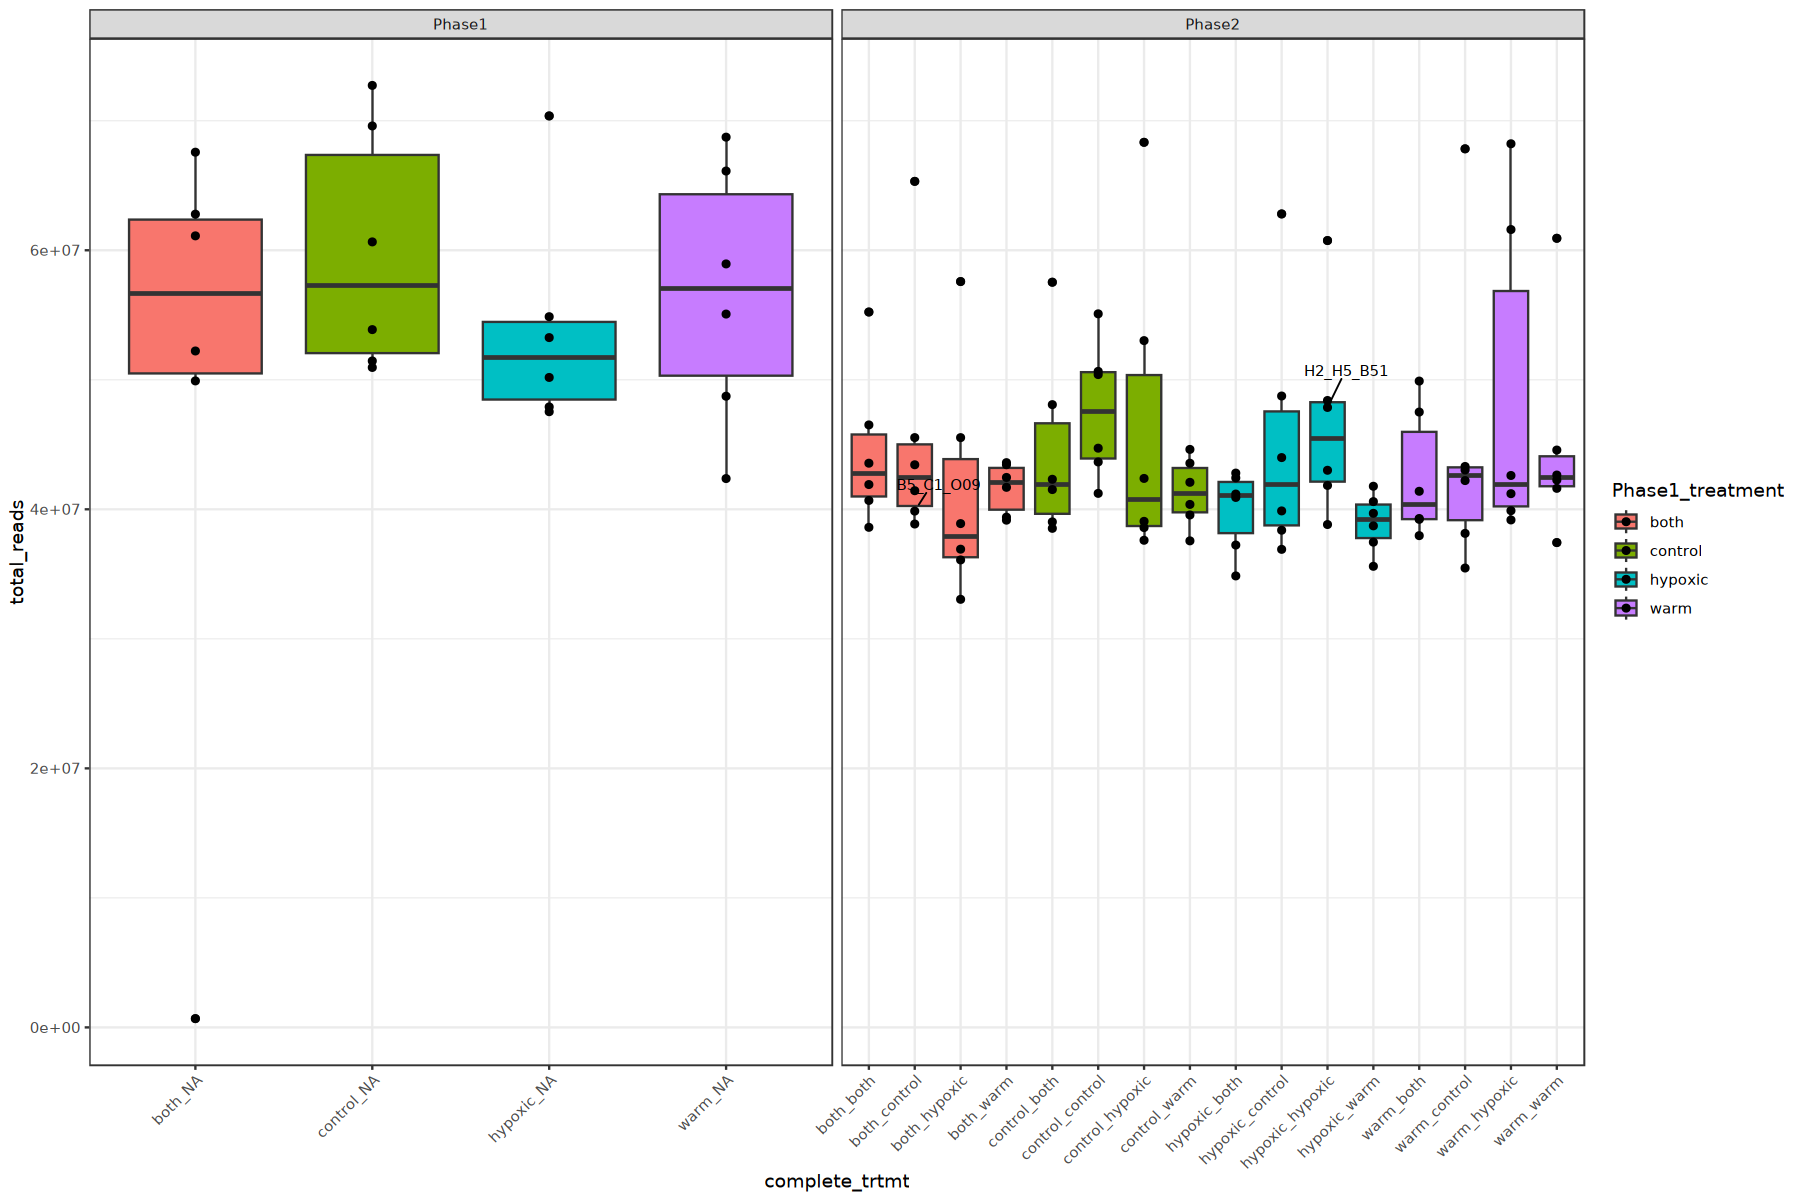

In [106]:
options(repr.plot.width=15, repr.plot.height=10)

outliers <- c("B5_C1_O09", "H2_H5_B51")


ggplot(df, aes(x = complete_trtmt, y = total_reads, fill = Phase1_treatment)) +
geom_boxplot() +
facet_wrap(~sample_type, scales = 'free_x') +
geom_point() +
 geom_text_repel(
    data = df %>% filter(Sample %in% outliers),
    aes(label = Sample),
    size = 3,
    color = "black",
    segment.color = "black",   # connector line
    segment.size = 0.4,
    box.padding = 0.8,         # space around label
    point.padding = 0.4,       # space around point
    force = 40,                # push labels farther away
    max.overlaps = Inf,
    show.legend = FALSE
  ) +
theme_bw() +
theme(axis.text.x = element_text(angle = 45, hjust = 1))

here, our outlier samples don't stand out from the other replicates

also it's weird that the phase 1 samples have such higher sequencing depth